# Ollama Parameter Guide: Understanding How Settings Affect Response Quality

This notebook provides a hands-on guide to using Ollama and understanding how different parameters affect text generation. We'll explore temperature, top_p, top_k, and other settings to help you optimize your prompts.

## Prerequisites
- Ollama installed and running locally
- A model downloaded (we'll use `gemma2:2b` in examples)
- Python requests library

## 1. Install and Import Required Libraries

First, let's install the necessary libraries and import modules for API interaction and data visualization.

In [ ]:
# Install required packages (run once)
# !pip install requests pandas matplotlib seaborn

In [ ]:
# Create a virtual environment named "myenv" and install requirements from "requirements.txt"
# Run these commands in a terminal (not inside Jupyter):

# !python -m venv myenv
# !myenv/bin/pip install -r requirements.txt

# If you are on Windows, use:
# !python -m venv myenv
# !myenv\Scripts\pip install -r requirements.txt

In [20]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, List
import time
from IPython.display import display, Markdown

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Setup Ollama Client Connection

Let's initialize our connection to the local Ollama server and verify that everything is working.

In [21]:
# Ollama API configuration
OLLAMA_URL = "http://localhost:11434"
GENERATE_ENDPOINT = f"{OLLAMA_URL}/api/generate"
MODELS_ENDPOINT = f"{OLLAMA_URL}/api/tags"

def check_ollama_connection():
    """Check if Ollama server is running and accessible."""
    try:
        response = requests.get(MODELS_ENDPOINT, timeout=5)
        if response.status_code == 200:
            models = response.json().get('models', [])
            print(f"✅ Ollama server is running!")
            print(f"📋 Available models: {len(models)}")
            for model in models[:5]:  # Show first 5 models
                print(f"   - {model['name']} ({model.get('size', 'unknown size')})")
            if len(models) > 5:
                print(f"   ... and {len(models) - 5} more")
            return True
        else:
            print(f"❌ Ollama server responded with status {response.status_code}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"❌ Cannot connect to Ollama server: {e}")
        print("💡 Make sure Ollama is installed and running: `ollama serve`")
        return False

# Test connection
check_ollama_connection()

✅ Ollama server is running!
📋 Available models: 6
   - qwen3:4b (2497293918)
   - qwen3:8b (5225388164)
   - huihui_ai/dolphin3-abliterated:8b (4920760656)
   - dolphin3:8b (4920757726)
   - gemma3:12b (8149190253)
   ... and 1 more


True

In [24]:
# Configuration for our experiments
DEFAULT_MODEL = "gemma3:1b"  # Change this to a model you have installed
TEST_PROMPT = "Spiega il concetto di intelligenza artificiale in modo semplice."

def generate_text(prompt: str, model: str = DEFAULT_MODEL, **options) -> Dict[str, Any]:
    """Generate text using Ollama API without streaming."""
    payload = {
        "model": model,
        "prompt": prompt,
        "stream": False,  # Important: no streaming for clear comparisons
        "options": options
    }
    
    try:
        start_time = time.time()
        response = requests.post(GENERATE_ENDPOINT, json=payload, timeout=60)
        end_time = time.time()
        
        if response.status_code == 200:
            result = response.json()
            result['generation_time'] = end_time - start_time
            result['options_used'] = options
            return result
        else:
            return {"error": f"HTTP {response.status_code}: {response.text}"}
    except Exception as e:
        return {"error": str(e)}

print(f"🎯 Using model: {DEFAULT_MODEL}")
print(f"📝 Test prompt: {TEST_PROMPT}")

🎯 Using model: gemma3:1b
📝 Test prompt: Spiega il concetto di intelligenza artificiale in modo semplice.


## 3. Basic Text Generation with Default Parameters

Let's start with a baseline generation using default parameters to establish what "normal" output looks like.

In [25]:
# Generate text with default parameters
print("🔄 Generating text with default parameters...")
baseline_result = generate_text(TEST_PROMPT)

if 'error' in baseline_result:
    print(f"❌ Error: {baseline_result['error']}")
else:
    print("✅ Generation completed!")
    print(f"⏱️  Time taken: {baseline_result['generation_time']:.2f} seconds")
    print(f"📊 Tokens generated: {baseline_result.get('eval_count', 'N/A')}")
    print("\n" + "="*50)
    print("📖 BASELINE RESPONSE:")
    print("="*50)
    print(baseline_result['response'])
    print("="*50)

🔄 Generating text with default parameters...
✅ Generation completed!
⏱️  Time taken: 6.61 seconds
📊 Tokens generated: 573

📖 BASELINE RESPONSE:
Ok, proviamo a spiegare l'intelligenza artificiale (IA) in modo semplice, senza complicazioni.

**L'Intelligenza Artificiale (IA) in parole semplici è...**

Immagina di avere un computer o un' macchina che può fare cose che normalmente richiederebbero l'intelligenza umana, come:

*   **Imparare:** Acquisire nuove informazioni e conoscenze.
*   **Risolvere problemi:** Trovare soluzioni a problemi complessi.
*   **Ragionare:** Capire relazioni e fare previsioni.
*   **Percepire:** Comprendere ciò che vede, ascolta o sente.
*   **Comprendere il linguaggio:** Leggere e capire parole e frasi.

**In pratica, l'IA si concentra sulla creazione di sistemi che *simulano* l'intelligenza umana.**  Non si tratta di far sì che un computer "pensi" come noi, ma di programmare i computer per agire in modo intelligente.

**Esistono diversi modi per farlo:**

*  

## 4. Exploring Temperature Effects

Temperature controls randomness in text generation:
- **Low temperature (0.1-0.3)**: More focused, consistent, predictable
- **Medium temperature (0.7-1.0)**: Balanced creativity and coherence
- **High temperature (1.2-2.0)**: More creative, diverse, but potentially less coherent

Let's test different temperature values with the same prompt.

In [26]:
# Test different temperature values
temperature_values = [0.1, 0.5, 1.0, 1.5]
temperature_results = {}

print("🌡️  Testing different temperature values...\n")

for temp in temperature_values:
    print(f"🔄 Generating with temperature = {temp}...")
    result = generate_text(TEST_PROMPT, temperature=temp)
    
    if 'error' not in result:
        temperature_results[temp] = result
        print(f"✅ Completed in {result['generation_time']:.2f}s")
    else:
        print(f"❌ Error: {result['error']}")
    print()

print(f"📊 Generated {len(temperature_results)} temperature variations")

🌡️  Testing different temperature values...

🔄 Generating with temperature = 0.1...
✅ Completed in 7.16s

🔄 Generating with temperature = 0.5...
✅ Completed in 7.16s

🔄 Generating with temperature = 0.5...
✅ Completed in 7.54s

🔄 Generating with temperature = 1.0...
✅ Completed in 7.54s

🔄 Generating with temperature = 1.0...
✅ Completed in 6.59s

🔄 Generating with temperature = 1.5...
✅ Completed in 6.59s

🔄 Generating with temperature = 1.5...
✅ Completed in 7.93s

📊 Generated 4 temperature variations
✅ Completed in 7.93s

📊 Generated 4 temperature variations


In [27]:
# Display temperature comparison results
for temp, result in temperature_results.items():
    print(f"\n🌡️  TEMPERATURE = {temp}")
    print("="*60)
    print(result['response'])
    print(f"\n📊 Stats: {result.get('eval_count', 'N/A')} tokens, {result['generation_time']:.2f}s")
    print("="*60)


🌡️  TEMPERATURE = 0.1
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice, senza troppi tecnicismi.

**Immagina di avere un cane che impara a fare cose.**

*   **Normalmente, un cane impara seguendo le tue istruzioni:** "Fai il tappo", "Fai la guardia".  Il cane impara a fare ciò che *tu* gli dici.
*   **L'IA è un po' come un cane che impara da solo.** Invece di darti istruzioni, gli dai *dati* (come immagini, testo, numeri) e gli chiedi di trovare delle *pattern* (come "questo è un gatto", "questo è un cane").  Poi, con l'aiuto dei dati, impara a fare cose nuove, senza che tu gli dica esattamente cosa fare.

**In parole povere, l'Intelligenza Artificiale è:**

*   **Far sì che le macchine "pensino" e "ragionino" come noi.**  Non si tratta di farle fare *tutto* automaticamente, ma di farle fare compiti che normalmente richiederebbero un'intelligenza umana.
*   **Usare computer e software per risolvere problemi.**  Questo può includere:
    *   **Riconoscere immagi

## 5. Testing Top-p (Nucleus Sampling) Parameter

Top-p (nucleus sampling) controls diversity by considering only the most probable tokens that make up the top-p probability mass:
- **Low top_p (0.1-0.3)**: Conservative, focuses on most likely tokens
- **Medium top_p (0.5-0.8)**: Balanced approach
- **High top_p (0.9-1.0)**: Considers more tokens, increases diversity

In [28]:
# Test different top_p values
top_p_values = [0.1, 0.5, 0.8, 0.95]
top_p_results = {}

print("🎯 Testing different top_p values...\n")

for top_p in top_p_values:
    print(f"🔄 Generating with top_p = {top_p}...")
    result = generate_text(TEST_PROMPT, top_p=top_p, temperature=0.8)  # Fixed temperature for fair comparison
    
    if 'error' not in result:
        top_p_results[top_p] = result
        print(f"✅ Completed in {result['generation_time']:.2f}s")
    else:
        print(f"❌ Error: {result['error']}")
    print()

print(f"📊 Generated {len(top_p_results)} top_p variations")

🎯 Testing different top_p values...

🔄 Generating with top_p = 0.1...
✅ Completed in 6.81s

🔄 Generating with top_p = 0.5...
✅ Completed in 6.81s

🔄 Generating with top_p = 0.5...
✅ Completed in 8.14s

🔄 Generating with top_p = 0.8...
✅ Completed in 8.14s

🔄 Generating with top_p = 0.8...
✅ Completed in 7.41s

🔄 Generating with top_p = 0.95...
✅ Completed in 7.41s

🔄 Generating with top_p = 0.95...
✅ Completed in 7.01s

📊 Generated 4 top_p variations
✅ Completed in 7.01s

📊 Generated 4 top_p variations


In [29]:
# Display top_p comparison results
for top_p, result in top_p_results.items():
    print(f"\n🎯 TOP_P = {top_p}")
    print("="*60)
    print(result['response'])
    print(f"\n📊 Stats: {result.get('eval_count', 'N/A')} tokens, {result['generation_time']:.2f}s")
    print("="*60)


🎯 TOP_P = 0.1
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice e comprensibile.

**In poche parole, l'Intelligenza Artificiale è farcire un computer con la capacità di "pensare" e "imparare" come gli umani.**

Ma non è così semplice come un robot che fa tutto da solo.  L'IA non è un'unica cosa, ma un insieme di tecniche che permettono ai computer di fare cose che normalmente richiederebbero l'intelligenza umana.

**Ecco alcuni punti chiave per capire meglio:**

* **Come funziona?**  L'IA si basa su "algoritmi" – regole e istruzioni che il computer segue per risolvere problemi.  Questi algoritmi vengono "addestrati" con grandi quantità di dati.
* **Imparare:**  L'IA non è programmata per fare qualcosa.  Invece, impara dai dati che le vengono forniti.  Ad esempio, se gli mostriamo tantissimi esempi di immagini di gatti, imparerà a riconoscere un gatto anche quando lo vediamo per la prima volta.
* **Esempi di IA che vediamo tutti i giorni:**
    * **Assistenti vir

## 6. Adjusting Max Tokens/Length Parameters

The `num_predict` parameter controls the maximum number of tokens to generate. Let's see how different limits affect response completeness.

In [30]:
# Test different token limits
token_limits = [50, 100, 200, 400]
token_results = {}

print("📏 Testing different token limits...\n")

for limit in token_limits:
    print(f"🔄 Generating with max {limit} tokens...")
    result = generate_text(TEST_PROMPT, num_predict=limit, temperature=0.7)
    
    if 'error' not in result:
        token_results[limit] = result
        actual_tokens = result.get('eval_count', 0)
        print(f"✅ Generated {actual_tokens} tokens in {result['generation_time']:.2f}s")
    else:
        print(f"❌ Error: {result['error']}")
    print()

print(f"📊 Generated {len(token_results)} token limit variations")

📏 Testing different token limits...

🔄 Generating with max 50 tokens...
✅ Generated 50 tokens in 0.70s

🔄 Generating with max 100 tokens...
✅ Generated 50 tokens in 0.70s

🔄 Generating with max 100 tokens...
✅ Generated 100 tokens in 1.17s

🔄 Generating with max 200 tokens...
✅ Generated 100 tokens in 1.17s

🔄 Generating with max 200 tokens...
✅ Generated 200 tokens in 2.30s

🔄 Generating with max 400 tokens...
✅ Generated 200 tokens in 2.30s

🔄 Generating with max 400 tokens...
✅ Generated 400 tokens in 4.55s

📊 Generated 4 token limit variations
✅ Generated 400 tokens in 4.55s

📊 Generated 4 token limit variations


In [31]:
# Display token limit comparison results
for limit, result in token_results.items():
    actual_tokens = result.get('eval_count', 0)
    print(f"\n📏 MAX TOKENS = {limit} (actual: {actual_tokens})")
    print("="*60)
    print(result['response'])
    print(f"\n📊 Generation time: {result['generation_time']:.2f}s")
    print("="*60)


📏 MAX TOKENS = 50 (actual: 50)
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice, senza tecnicismi eccessivi.

**Immagina di insegnare a un computer a fare delle cose che normalmente richiederebbero l'

📊 Generation time: 0.70s

📏 MAX TOKENS = 100 (actual: 100)
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice e comprensibile.

**Immagina di avere un cane che impara a fare cose da solo.**  L'IA è un po' come insegnare a un computer a fare delle cose che normalmente richiederebbero l'intelligenza umana.

**In parole povere, l'IA è la capacità di un computer di:**

* **Imparare:**  Analizzare grandi

📊 Generation time: 1.17s

📏 MAX TOKENS = 200 (actual: 200)
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice. Immagina di voler insegnare a un computer a fare le cose che fanno noi, ma in modo che possa imparare e migliorare da solo. Ecco in poche parole, l'IA è **fare in modo che i computer possano pensare e agire in modo

## 7. Combining Multiple Parameters

Now let's experiment with combinations of parameters to see their cumulative effects. We'll create some preset "personalities" for text generation.

In [32]:
# Define parameter combinations for different "personalities"
parameter_presets = {
    "Conservative": {
        "temperature": 0.2,
        "top_p": 0.3,
        "top_k": 10,
        "description": "Focused, predictable, consistent responses"
    },
    "Balanced": {
        "temperature": 0.7,
        "top_p": 0.8,
        "top_k": 40,
        "description": "Good balance of creativity and coherence"
    },
    "Creative": {
        "temperature": 1.2,
        "top_p": 0.95,
        "top_k": 100,
        "description": "Highly creative, diverse, potentially unexpected"
    },
    "Experimental": {
        "temperature": 1.5,
        "top_p": 0.98,
        "top_k": 200,
        "description": "Maximum creativity and randomness"
    }
}

combo_results = {}

print("🎭 Testing parameter combination presets...\n")

for preset_name, params in parameter_presets.items():
    description = params.pop('description')
    print(f"🔄 Testing '{preset_name}' preset ({description})...")
    
    result = generate_text(TEST_PROMPT, **params)
    
    if 'error' not in result:
        combo_results[preset_name] = {
            'result': result,
            'params': params,
            'description': description
        }
        print(f"✅ Completed in {result['generation_time']:.2f}s")
    else:
        print(f"❌ Error: {result['error']}")
    print()

print(f"📊 Generated {len(combo_results)} preset variations")

🎭 Testing parameter combination presets...

🔄 Testing 'Conservative' preset (Focused, predictable, consistent responses)...
✅ Completed in 7.38s

🔄 Testing 'Balanced' preset (Good balance of creativity and coherence)...
✅ Completed in 7.38s

🔄 Testing 'Balanced' preset (Good balance of creativity and coherence)...
✅ Completed in 9.21s

🔄 Testing 'Creative' preset (Highly creative, diverse, potentially unexpected)...
✅ Completed in 9.21s

🔄 Testing 'Creative' preset (Highly creative, diverse, potentially unexpected)...
✅ Completed in 6.83s

🔄 Testing 'Experimental' preset (Maximum creativity and randomness)...
✅ Completed in 6.83s

🔄 Testing 'Experimental' preset (Maximum creativity and randomness)...
✅ Completed in 9.52s

📊 Generated 4 preset variations
✅ Completed in 9.52s

📊 Generated 4 preset variations


In [33]:
# Display combination results
for preset_name, data in combo_results.items():
    result = data['result']
    params = data['params']
    description = data['description']
    
    print(f"\n🎭 {preset_name.upper()} PRESET")
    print(f"📝 {description}")
    print(f"⚙️  Parameters: {params}")
    print("="*60)
    print(result['response'])
    print(f"\n📊 Stats: {result.get('eval_count', 'N/A')} tokens, {result['generation_time']:.2f}s")
    print("="*60)


🎭 CONSERVATIVE PRESET
📝 Focused, predictable, consistent responses
⚙️  Parameters: {'temperature': 0.2, 'top_p': 0.3, 'top_k': 10}
Ok, proviamo a spiegare l'Intelligenza Artificiale (IA) in modo semplice e comprensibile.

**In poche parole, l'Intelligenza Artificiale è farcire un computer con la capacità di "pensare" e "imparare" come gli umani.**

Ma non è così semplice come un robot che fa tutto da solo.  L'IA non è un'unica cosa, ma un insieme di tecniche che permettono ai computer di fare cose che normalmente richiederebbero l'intelligenza umana.

**Ecco alcuni punti chiave per capire meglio:**

* **Come funziona?**  L'IA si basa su "algoritmi" – regole e istruzioni che il computer segue per risolvere problemi.  Questi algoritmi vengono "addestrati" con grandi quantità di dati.
* **Imparare:**  L'IA non è programmata per fare qualcosa.  Invece, impara dai dati che le vengono forniti.  Ad esempio, se gli mostriamo tantissimi esempi di immagini di gatti, imparerà a riconoscere un ga

## 8. Parameter Comparison Visualization

Let's create some visualizations to better understand how different parameters affect generation characteristics.

In [35]:
# Prepare data for visualization
def create_comparison_dataframe():
    data = []
    
    # Temperature data
    for temp, result in temperature_results.items():
        data.append({
            'experiment': 'Temperature',
            'parameter_value': temp,
            'generation_time': result['generation_time'],
            'token_count': result.get('eval_count', 0),
            'response_length': len(result['response'])
        })
    
    # Top-p data
    for top_p, result in top_p_results.items():
        data.append({
            'experiment': 'Top-p',
            'parameter_value': top_p,
            'generation_time': result['generation_time'],
            'token_count': result.get('eval_count', 0),
            'response_length': len(result['response'])
        })
    
    # Token limit data
    for limit, result in token_results.items():
        data.append({
            'experiment': 'Token Limit',
            'parameter_value': limit,
            'generation_time': result['generation_time'],
            'token_count': result.get('eval_count', 0),
            'response_length': len(result['response'])
        })
    
    return pd.DataFrame(data)

# Create the dataframe
df = create_comparison_dataframe()
print("📊 Comparison data prepared:")
display(df)

📊 Comparison data prepared:


,experiment,parameter_value,generation_time,token_count,response_length
0,Temperature,0.10,7.161517,618,2193
1,Temperature,0.50,7.542956,637,2502
2,Temperature,1.00,6.589168,578,2245
3,Temperature,1.50,7.934847,698,2685
4,Top-p,0.10,6.811741,588,2251
5,Top-p,0.50,8.138953,689,2757
6,Top-p,0.80,7.412593,650,2392
7,Top-p,0.95,7.012232,616,2434
8,Token Limit,50.00,0.695154,50,193
9,Token Limit,100.00,1.170564,100,365


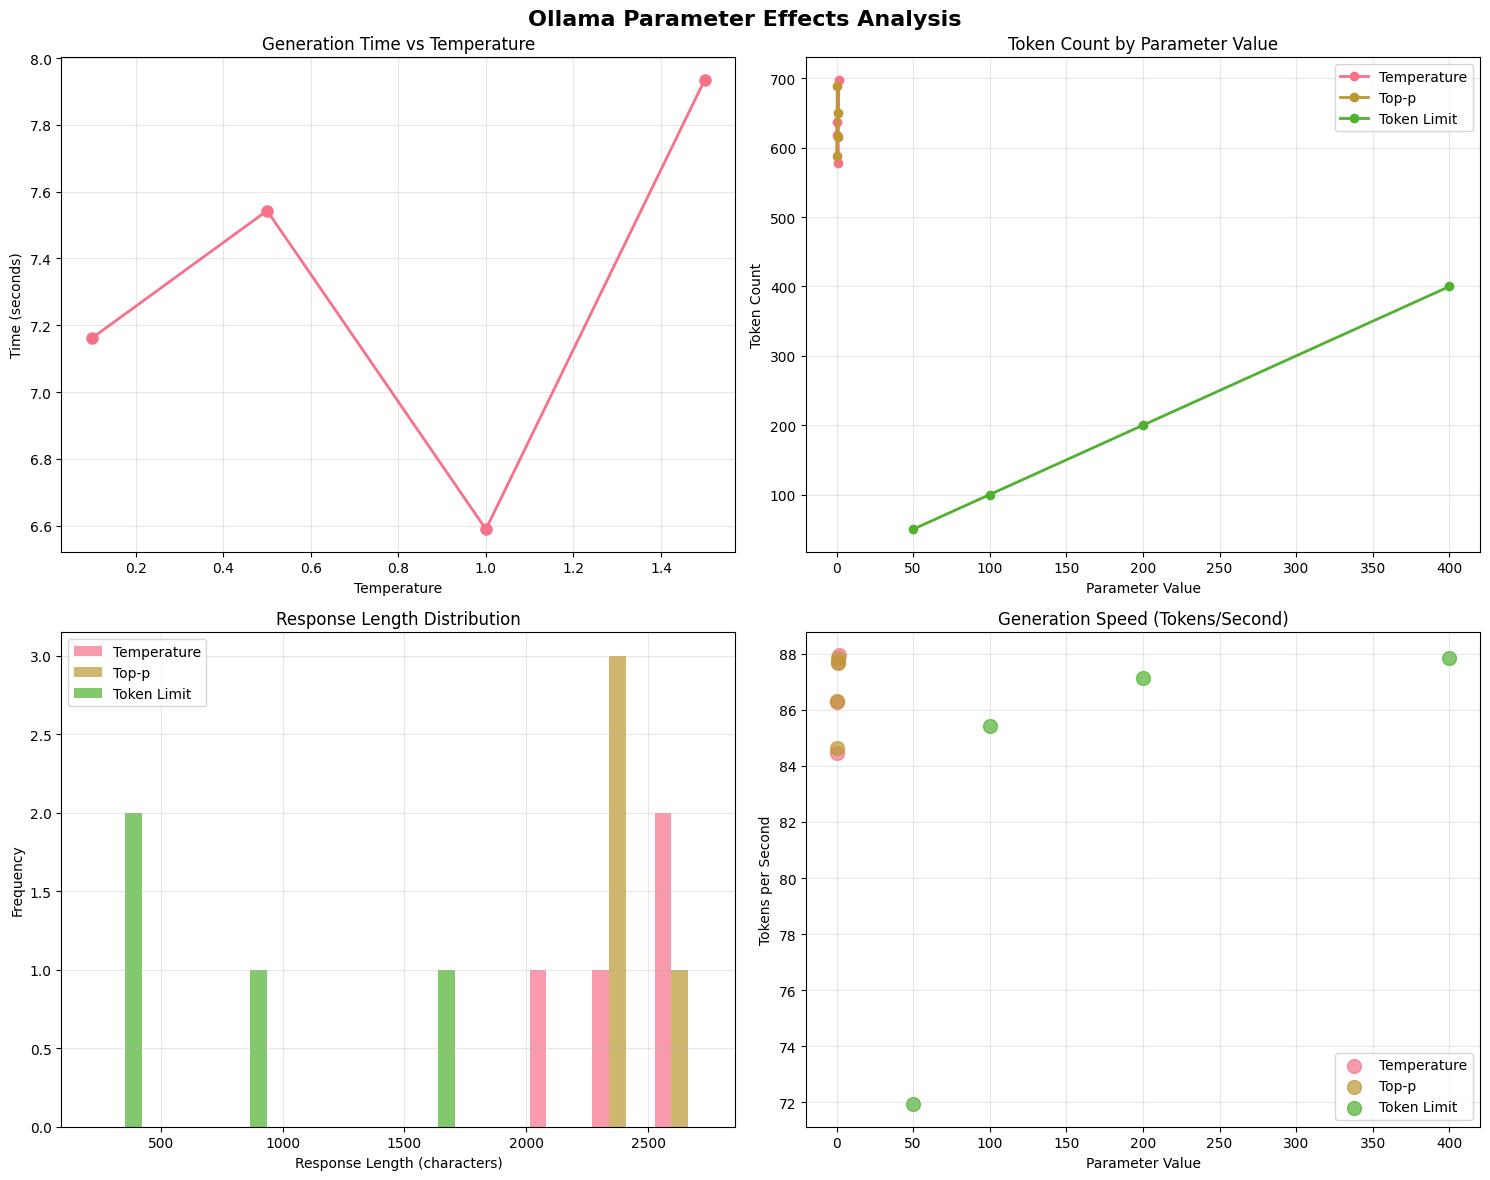

In [36]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Ollama Parameter Effects Analysis', fontsize=16, fontweight='bold')

# 1. Generation Time by Parameter
temp_data = df[df['experiment'] == 'Temperature']
axes[0, 0].plot(temp_data['parameter_value'], temp_data['generation_time'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_title('Generation Time vs Temperature')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Time (seconds)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Token Count by Parameter
for experiment in df['experiment'].unique():
    exp_data = df[df['experiment'] == experiment]
    axes[0, 1].plot(exp_data['parameter_value'], exp_data['token_count'], 'o-', label=experiment, linewidth=2, markersize=6)
axes[0, 1].set_title('Token Count by Parameter Value')
axes[0, 1].set_xlabel('Parameter Value')
axes[0, 1].set_ylabel('Token Count')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Response Length Distribution
axes[1, 0].hist([df[df['experiment'] == exp]['response_length'] for exp in df['experiment'].unique()], 
                bins=10, alpha=0.7, label=df['experiment'].unique())
axes[1, 0].set_title('Response Length Distribution')
axes[1, 0].set_xlabel('Response Length (characters)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Generation Speed (tokens per second)
df['tokens_per_second'] = df['token_count'] / df['generation_time']
for experiment in df['experiment'].unique():
    exp_data = df[df['experiment'] == experiment]
    axes[1, 1].scatter(exp_data['parameter_value'], exp_data['tokens_per_second'], 
                      label=experiment, s=100, alpha=0.7)
axes[1, 1].set_title('Generation Speed (Tokens/Second)')
axes[1, 1].set_xlabel('Parameter Value')
axes[1, 1].set_ylabel('Tokens per Second')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# Create a summary table of all experiments
summary_data = []

# Add temperature results
for temp, result in temperature_results.items():
    summary_data.append({
        'Experiment': 'Temperature',
        'Value': temp,
        'Tokens': result.get('eval_count', 0),
        'Time (s)': f"{result['generation_time']:.2f}",
        'Speed (tok/s)': f"{result.get('eval_count', 0) / result['generation_time']:.1f}",
        'Response Preview': result['response'][:100] + "..." if len(result['response']) > 100 else result['response']
    })

# Add preset combination results
for preset_name, data in combo_results.items():
    result = data['result']
    summary_data.append({
        'Experiment': f'Preset: {preset_name}',
        'Value': str(data['params']),
        'Tokens': result.get('eval_count', 0),
        'Time (s)': f"{result['generation_time']:.2f}",
        'Speed (tok/s)': f"{result.get('eval_count', 0) / result['generation_time']:.1f}",
        'Response Preview': result['response'][:100] + "..." if len(result['response']) > 100 else result['response']
    })

summary_df = pd.DataFrame(summary_data)
print("📋 EXPERIMENT SUMMARY")
print("="*80)
display(summary_df)

📋 EXPERIMENT SUMMARY


,Experiment,Value,Tokens,Time (s),Speed (tok/s),Response Preview
0,Temperature,0.1,618,7.16,86.3,"Ok, proviamo a spiegare l'Intelligenza Artific..."
1,Temperature,0.5,637,7.54,84.4,"Ok, proviamo a spiegare l'Intelligenza Artific..."
2,Temperature,1.0,578,6.59,87.7,"Ok, proviamo a spiegare l'Intelligenza Artific..."
3,Temperature,1.5,698,7.93,88.0,"Ok, proviamo a spiegare l'Intelligenza Artific..."
4,Preset: Conservative,"{'temperature': 0.2, 'top_p': 0.3, 'top_k': 10}",642,7.38,87.0,"Ok, proviamo a spiegare l'Intelligenza Artific..."
5,Preset: Balanced,"{'temperature': 0.7, 'top_p': 0.8, 'top_k': 40}",810,9.21,88.0,"Ok, proviamo a spiegare l'Intelligenza Artific..."
6,Preset: Creative,"{'temperature': 1.2, 'top_p': 0.95, 'top_k': 100}",592,6.83,86.7,"Ok, cerchiamo di spiegare l'Intelligenza Artif..."
7,Preset: Experimental,"{'temperature': 1.5, 'top_p': 0.98, 'top_k': 200}",794,9.52,83.4,"Ok, proviamo a spiegare l'intelligenza artific..."


## 🎯 Key Takeaways and Best Practices

Based on our experiments, here are the key insights:

### Parameter Guidelines:

1. **Temperature**:
   - Use 0.1-0.3 for factual, consistent responses
   - Use 0.7-1.0 for creative writing and brainstorming
   - Use 1.2+ for experimental, highly diverse outputs

2. **Top-p (nucleus sampling)**:
   - Use 0.1-0.5 for focused, coherent responses
   - Use 0.8-0.95 for balanced creativity
   - Combine with appropriate temperature for best results

3. **Token limits**:
   - Set based on your use case (50 for summaries, 400+ for stories)
   - Monitor actual vs. requested tokens

### Recommended Presets:
- **Documentation/FAQ**: `temperature=0.2, top_p=0.3, top_k=10`
- **Creative Writing**: `temperature=0.8, top_p=0.9, top_k=50`
- **Code Generation**: `temperature=0.1, top_p=0.5, top_k=20`
- **Brainstorming**: `temperature=1.0, top_p=0.95, top_k=100`

## 🚀 Next Steps

Try experimenting with:
1. Different prompts and see how parameters affect various types of content
2. Other parameters like `repeat_penalty` and `seed` for reproducibility
3. Different models to see how parameter sensitivity varies
4. Combining multiple generations with voting or selection mechanisms

Remember: The "best" parameters depend on your specific use case, model, and desired output characteristics!